<a href="https://colab.research.google.com/github/Sourjya261/IDRid_EX_Segmentation/blob/main/training_cropnblur_resunet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Resunet with decreasing conv blocks with increasing depth
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Input, Dropout, MaxPooling2D, concatenate
from tensorflow.keras.models import Model

def batchnorm_relu(inputs):
    x = BatchNormalization()(inputs)
    x = Activation("relu")(x)
    return x

def res_conv_block(inputs,num_filters,strides):
    x = batchnorm_relu(inputs)
    x = Conv2D(num_filters, 3, padding="same", strides=strides,kernel_initializer = "he_normal")(x)
    x = Dropout(0.1)(x)
    x = batchnorm_relu(x)
    x = Conv2D(num_filters, 3, padding="same", strides=1,kernel_initializer = "he_normal")(x)
    
    s = Conv2D(num_filters, 1, padding="same", strides=strides,kernel_initializer = "he_normal")(inputs)
    s = BatchNormalization()(s)
    
    x = x + s
    return x


def residual_block_1(inputs, num_filters, strides):
   
   c1 = res_conv_block(inputs,num_filters,strides = 1)
   c2 = res_conv_block(c1,num_filters,strides = 1)
   c3 = res_conv_block(c2,num_filters,strides = strides)
   return c3

def residual_block_2(inputs, num_filters, strides):
  c1 = res_conv_block(inputs,num_filters,strides = 1)
  c2 = res_conv_block(c1,num_filters,strides = strides)
  return c2

def residual_block_3(inputs, num_filters, strides):
  c1 = res_conv_block(inputs,num_filters,strides = strides)

  return c1
  

def decoder_block_1(inputs, skip_features, num_filters):
    x = UpSampling2D((2, 2))(inputs)
    x = Concatenate()([x, skip_features])
    x = residual_block_1(x, num_filters, strides=1)
    return x

def decoder_block_2(inputs, skip_features, num_filters):
    x = UpSampling2D((2, 2))(inputs)
    x = Concatenate()([x, skip_features])
    x = residual_block_2(x, num_filters, strides=1)
    return x

def decoder_block_3(inputs, skip_features, num_filters):
    x = UpSampling2D((2, 2))(inputs)
    x = Concatenate()([x, skip_features])
    x = residual_block_3(x, num_filters, strides=1)
    return x

def build_resunet(input_shape):
    inputs = Input(input_shape)
    '''encoder 1'''
    p1 = residual_block_1(inputs,num_filters=32,strides=1)
    '''encoder 2'''
    p2 = residual_block_2(p1,num_filters=64,strides=2)
    '''encoder 3'''
    p3 = residual_block_3(p2,num_filters=128,strides=2)
    
    
    '''bridge'''
    p4 = residual_block_1(p3,num_filters=256,strides=2)

    '''decoder 1'''
    d1 = decoder_block_3(p4,p3,num_filters=128)
    '''decoder 2'''
    d2 = decoder_block_2(d1,p2,num_filters=64)
    '''decoder 3'''
    d3 = decoder_block_1(d2,p1,num_filters=32)
    """ Classifier """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d3)

    """ Model """
    model = Model(inputs, outputs)
    return model

In [ ]:
model = build_resunet((512,512,3))
model.summary()

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Input, ZeroPadding2D,Dropout,Dense, GlobalAveragePooling2D,Reshape,Multiply
from tensorflow.keras.models import Model

def batchnorm_relu(inputs):
    x = BatchNormalization()(inputs)
    x = Activation("relu")(x)
    return x
def squeeze_excite_block(inputs, ratio=8):
    init = inputs       ## (b, 128, 128, 32)
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)     ## (b, 32)   -> (b, 1, 1, 32)
    se = Reshape(se_shape)(se)
    se = Dense(filters//ratio, activation="relu", use_bias=False)(se)
    se = Dense(filters, activation="sigmoid", use_bias=False)(se)

    x = Multiply()([inputs, se])
    return x

def residual_block(inputs, num_filters, strides=1):
    """ Convolutional Layer """
    x = batchnorm_relu(inputs)
    x = Conv2D(num_filters, 3, padding="same", strides=strides,kernel_initializer = "he_normal")(x)
    x = Dropout(0.1)(x)
    x = batchnorm_relu(x)
    x = Conv2D(num_filters, 3, padding="same", strides=1,kernel_initializer = "he_normal")(x)

    """ Shortcut Connection """
    s = Conv2D(num_filters, 1, padding="same", strides=strides,kernel_initializer="he_normal")(inputs)
    x = x + s
    return x

def decoder_block(inputs, skip_features, num_filters):
    x = UpSampling2D((2, 2))(inputs)
    x = Concatenate()([x, skip_features])
    x = residual_block(x, num_filters, strides=1)
    #x = squeeze_excite_block(x)
    return x

def build_resunet(input_shape):
    inputs = Input(input_shape)

    """ Encoder 1 """
    x = Conv2D(64, 3, padding="same", strides=1,kernel_initializer="he_normal")(inputs)
    x = batchnorm_relu(x)
    x = Conv2D(64, 3, padding="same", strides=1,kernel_initializer="he_normal")(x)
    s = Conv2D(64, 1, padding="same", strides=1,kernel_initializer="he_normal")(inputs)
    s1 = x + s

    """ Encoder 2 and 3 """
    s2 = residual_block(s1, 128, strides=2)
    s3 = residual_block(s2, 256, strides=2)

    """ Bridge """
    b = residual_block(s3, 512, strides=2)

    """ Decoder 1, 2, 3 """
    d1 = decoder_block(b, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)

    """ Classifier """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d3)

    """ Model """
    model = Model(inputs, outputs)
    return model

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
import matplotlib.pyplot as plt
from PIL import Image


76


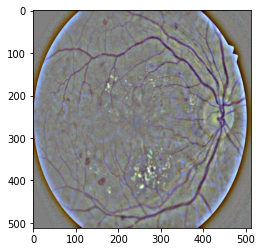

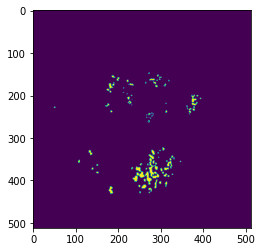

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/IDRID_Dataset/cropnblur/train/"
images = sorted(glob(os.path.join(path, "images_aug", "*.jpg")))
masks = sorted(glob(os.path.join(path,"masks_aug","*tif")))
x=cv2.imread(images[0])
y=cv2.imread(masks[0],cv2.IMREAD_GRAYSCALE)
x = cv2.resize(x,(512,512),interpolation=cv2.INTER_AREA)
x = x/255.0
y = cv2.resize(y,(512,512),interpolation=cv2.INTER_AREA)
print(np.max(y))
y = y.astype(np.float32)
y = y/np.max(y)
y = y>0.5
plt.imshow(x)
plt.show()
plt.imshow(y)
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
def preprocess(img, sigmaX=10):  
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), sigmaX), -4, 128)

    return img

In [ ]:
""" Global Parameters """
H = 512
W = 512

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def load_data(path,split=0.1):

    images = sorted(glob(os.path.join(path, "images_aug", "*.jpg")))
    masks = sorted(glob(os.path.join(path, "masks_aug", "*.tif")))
    
    print(len(images))
    print(len(masks))
    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)


    return (train_x, train_y), (valid_x, valid_y)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    #x = preprocess(x,5)
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    threshold,thresh = cv2.threshold(x,75,255,cv2.THRESH_BINARY)
    x = thresh
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch_size=4):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(10)
    return dataset

In [ ]:
if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("/content/drive/MyDrive/Colab Notebooks/IDRID_EX_segementation/files")

    """ Hyperparameters """
    batch_size = 4
    lr = 1e-4
    num_epochs = 100
    model_path = os.path.join("/content/drive/MyDrive/Colab Notebooks/IDRID_EX_segementation/files/", "double_resunet_cropnblur.h5")
    csv_path = os.path.join("/content/drive/MyDrive/Colab Notebooks/IDRID_EX_segementation/files/", "double_resunet_cropnblur.csv")

    """ Dataset """
    dataset_path = "/content/drive/MyDrive/Colab Notebooks/IDRID_Dataset/cropnblur/train/"
    (train_x, train_y),(test_x, test_y) = load_data(dataset_path)
    train_x, train_y = shuffling(train_x, train_y)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    
    print(f"Test: {len(test_x)} - {len(test_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch_size)
    valid_dataset = tf_dataset(test_x, test_y, batch_size)

    train_steps = len(train_dataset)
    valid_steps = len(valid_dataset)

    """ Model """
    model = build_resunet((H, W, 3))
    metrics = [dice_coef, iou, Recall(), Precision()]
    model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=metrics)

    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        TensorBoard(),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
    ]


216
216
Train: 195 - 195
Test: 21 - 21


In [ ]:
model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        steps_per_epoch=train_steps,
        validation_steps=valid_steps,
        callbacks=callbacks
)

Epoch 1/100
49/49 [==============================] - ETA: 0s - loss: 0.6633 - dice_coef: 0.3379 - iou: 0.2151 - recall: 0.4035 - precision: 0.1922
Epoch 1: val_loss improved from inf to 1.00000, saving model to /content/drive/MyDrive/Colab Notebooks/IDRID_EX_segementation/files/resunet_cropnblur.h5
49/49 [==============================] - 347s 6s/step - loss: 0.6633 - dice_coef: 0.3379 - iou: 0.2151 - recall: 0.4035 - precision: 0.1922 - val_loss: 1.0000 - val_dice_coef: 8.2059e-17 - val_iou: 4.1315e-17 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/100
49/49 [==============================] - ETA: 0s - loss: 0.4512 - dice_coef: 0.5495 - iou: 0.3851 - recall: 0.5035 - precision: 0.6586
Epoch 2: val_loss improved from 1.00000 to 0.99815, saving model to /content/drive/MyDrive/Colab Notebooks/IDRID_EX_segementation/files/resunet_cropnblur.h5
49/49 [==============================] - 76s 2s/step - loss: 0.4512 - dice_coef: 0.5495 - iou: 0.3851 - recall: 0.503

In [ ]:
from tensorflow.keras.utils import CustomObjectScope
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
import pandas as pd

In [ ]:
""" Loading the model """
with CustomObjectScope({"iou": iou, "dice_coef": dice_coef, "dice_loss": dice_loss}):
  resunet_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/IDRID_EX_segementation/files/resunet_cropnblur.h5")

In [ ]:
for layer in tqdm(resunet_model.layers):
  layer.trainable = False

100%|██████████| 68/68 [00:00<00:00, 15121.02it/s]


In [ ]:
resunet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Input, ZeroPadding2D,Dropout,Dense, GlobalAveragePooling2D,Reshape,Multiply,MaxPooling2D
from tensorflow.keras.models import Model

def batchnorm_relu(inputs):
    x = BatchNormalization()(inputs)
    x = Activation("relu")(x)
    return x
def squeeze_excite_block(inputs, ratio=8):
    init = inputs       ## (b, 128, 128, 32)
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)     ## (b, 32)   -> (b, 1, 1, 32)
    se = Reshape(se_shape)(se)
    se = Dense(filters//ratio, activation="relu", use_bias=False)(se)
    se = Dense(filters, activation="sigmoid", use_bias=False)(se)

    x = Multiply()([inputs, se])
    return x

def conv_block(inputs, num_filters, strides=1):
    """ Convolutional Layer """
    x = batchnorm_relu(inputs)
    x = Conv2D(num_filters, 3, padding="same", strides=strides,kernel_initializer = "he_normal")(x)
    x = Dropout(0.1)(x)
    x = batchnorm_relu(x)
    x = Conv2D(num_filters, 3, padding="same", strides=1,kernel_initializer = "he_normal")(x)
    x = squeeze_excite_block(x)
    return x

def decoder_block(inputs, skip_1,skip_2, num_filters):
    x = UpSampling2D((2, 2))(inputs)
    x = Concatenate()([x, skip_1, skip_2])
    x = conv_block(x, num_filters, strides=1)

    return x





def build_se_unet(input_shape):
    inputs = Input(input_shape)
    new_model = Model(inputs,resunet_model.output)
    output_1  = new_model(inputs)
    
    x = (new_model.input) * output_1
    x = Conv2D(64, 3, padding="same", strides=1,kernel_initializer = "he_normal")(x)
    x = batchnorm_relu(x)
    x = Dropout(0.1)(x)
    x = Conv2D(64, 3, padding="same", strides=1,kernel_initializer = "he_normal")(x)
    x = squeeze_excite_block(x)

    c1 = x
    c2 = conv_block(c1,128,strides=1)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = conv_block(p2,256,strides=1)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = conv_block(p3,512,strides=1)
    p4 = MaxPooling2D((2,2))(c4)

    u5 = decoder_block(p4,p3,(new_model.get_layer("activation_5")).output,256)
    u6 = decoder_block(u5,p2,(new_model.get_layer("activation_3")).output,128)
    u7 = decoder_block(u6,c1,(new_model.get_layer("activation_1")).output,64)

    outputs = Conv2D(1, 1, padding="same", strides=1,activation='sigmoid')(u7)
    """ Model """
    final_model = Model(new_model.input, outputs)
    return final_model

In [ ]:
double_resunet_model = build_se_unet((512,512,3))

ValueError: ignored

In [ ]:
new_model.summary()

NameError: ignored